# Capstone 3 - Michael Govan

## Business Problem Understanding

**Context**  
Sebuah perusahaan e-commerce ('Perusahaan') memiliki sebuah project untuk mengetahui apakah customer yang bertransaksi menggunakan platform mereka akan berhenti dan tidak menggunakannya lagi. Perusahaan ingin menjaga pelanggan tersebut, dan memberikan promo atau diskon semenarik mungkin untuk mempertahankan pelanggan tersebut tetap bertransaksi pada platform mereka. Informasi terkait beberapa data customer telah dimiliki dari para pelanggan e-commerce

Target:  
0 : Pelanggan tidak berhenti dan akan tetap bertransaksi menggunakan platform Perusahaan.  
1 : Pelanggan akan berhenti dan tidak lagi bertransaksi menggunakan platform Perusahaan.

**Problem Statement :**  
Perusahaan hanya memiliki dana yang terbatas untuk dapat digunakan sebagai *budget* untuk promo dan/atau diskon kepada para pelangganya. Apabila mencoba untuk tetap memberikan promo pada semua pelanggan, dikhawatirkan perusahaan akan mengalami kerugian, dan tidak dapat mengakomodir kebutuhan biaya operasional Perusahaandalam waktu dekat.

Perusahaan juga ingin mencegah adanya pelanggan yang akan *churn* dikemudian hari, sehingga perlu adanya pertimbangan yang matang sebelum memilih pelanggan baru.

Goals :  
Untuk menjaga promo tersebut tetap efisien dan ekonomis, dan meminimalisir biaya marketing dan/atau promo yang akan menjadi sumberdaya model mempertahankan pelanggan e-commercenya, Perusahaan perlu mengetahui pelanggan mana saja yang akan mereka tawarkan promo dan diskon tersebut.

Perusahaan juga ingin mengetahui faktor/variabel apa saja yang akan berdampak terhadap keputusan pelanggan atas berhenti atau tidaknya menggunakan platform mereka. Dengan mengetahui hal tersebut, Perusahaan juga akan dapat memperkirakan pelanggan baru yang dapat di *acquire* guna menseleksi pelanggan yang akan setia terhadap platform mereka.

In [297]:
# Library
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import SCORERS
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, recall_score
from sklearn.metrics import precision_score, roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Ignore Warning
import sys
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv("C:/File/Purwadhika/3. Machine Learning/Capstone 3/data_ecommerce_customer_churn.csv")

## Data Cleaning

In [198]:
# Menggabungkan Category Mobile dan Mobile Phone
df['PreferedOrderCat'] = df['PreferedOrderCat'].apply(lambda x : 'Mobile Phone' if x == 'Mobile' else x)

Laptop & Accessory    1458
Mobile Phone           887
Fashion                585
Mobile                 559
Grocery                273
Others                 179
Name: PreferedOrderCat, dtype: int64

In [219]:
### Missing Value
round(df.isna().sum()/len(df)*100,2).sort_values(ascending=False)
# Terdapat 3 kolom dengan Missing Value, yaitu: DaySinceLastOrder (5.4%), Tenure (4.9%), WarehouseToHome (4.3%)

DaySinceLastOrder           5.40
Tenure                      4.92
WarehouseToHome             4.29
NumberOfDeviceRegistered    0.00
PreferedOrderCat            0.00
SatisfactionScore           0.00
MaritalStatus               0.00
NumberOfAddress             0.00
Complain                    0.00
CashbackAmount              0.00
Churn                       0.00
dtype: float64

In [278]:
print(df['Churn'].value_counts())
print(round(df['Churn'].value_counts()/len(df)*100,1))

0    3267
1     674
Name: Churn, dtype: int64
0    82.9
1    17.1
Name: Churn, dtype: float64


In [3]:
df.dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
Tenure,3365.0,10.177712,8.512943,0.0,3.00,9.00,16.00,61.00
WarehouseToHome,3365.0,15.713819,8.513705,5.0,9.00,14.00,21.00,127.00
NumberOfDeviceRegistered,3365.0,3.698960,1.024092,1.0,3.00,4.00,4.00,6.00
SatisfactionScore,3365.0,3.094205,1.381156,1.0,2.00,3.00,4.00,5.00
NumberOfAddress,3365.0,4.296582,2.626242,1.0,2.00,3.00,6.00,22.00
Complain,3365.0,0.283507,0.450767,0.0,0.00,0.00,1.00,1.00
DaySinceLastOrder,3365.0,4.780089,3.685837,0.0,2.00,4.00,8.00,46.00
CashbackAmount,3365.0,179.774725,48.293472,0.0,148.42,165.14,191.74,324.99
Churn,3365.0,0.151560,0.358647,0.0,0.00,0.00,0.00,1.00


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [242]:
# isi Missing Value
df['Tenure'].fillna(df['Tenure'].median(), inplace = True) # data yang memiliki missing value tidak akan di-drop melainkan akan diisi median
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace = True) # karena tidak terdistribusi normal, diisi menggunakan median
df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median(), inplace = True) # karena tidak terdistribusi normal, diisi menggunakan median

## 2 Exploratory Data Analysis

In [247]:
df[['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder','CashbackAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
Tenure,3941.0,10.028165,8.290290,0.0,3.0,9.00,15.00,61.00
WarehouseToHome,3941.0,15.579802,8.275800,5.0,9.0,14.00,20.00,127.00
NumberOfAddress,3941.0,4.237757,2.626699,1.0,2.0,3.00,6.00,22.00
DaySinceLastOrder,3941.0,4.448871,3.583909,0.0,2.0,3.00,7.00,46.00
CashbackAmount,3941.0,176.707419,48.791784,0.0,145.7,163.34,195.25,324.99


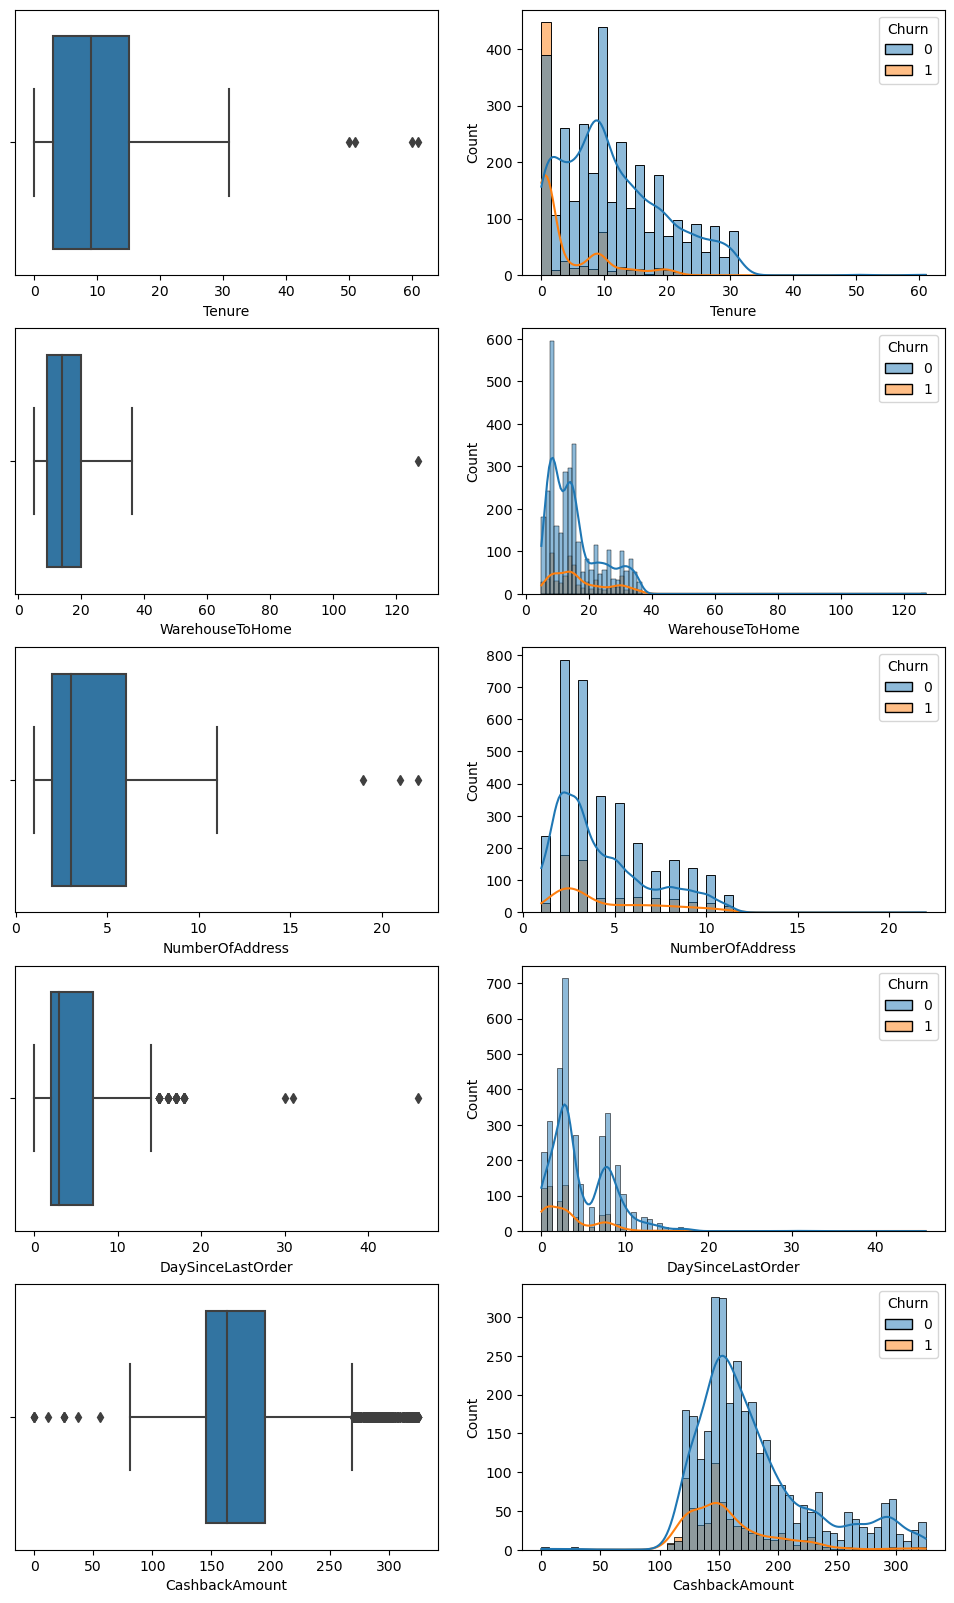

In [253]:
# Diagram distribusi pada variabel numerik
fig, axs =  plt.subplots(5, 2, figsize=(12,20))

# Tenure
sns.boxplot(df['Tenure'], ax=axs[0][0])
sns.histplot (data=df, x= 'Tenure', hue = 'Churn', kde=True, ax=axs[0][1])

# WarehouseToHome
sns.boxplot(df['WarehouseToHome'], ax=axs[1][0])
sns.histplot (data=df, x= 'WarehouseToHome', hue = 'Churn', kde=True, ax=axs[1][1])

# Number of Address
sns.boxplot(df['NumberOfAddress'], ax=axs[2][0])
sns.histplot (data=df, x= 'NumberOfAddress', hue = 'Churn', kde=True, ax=axs[2][1])

# DaySinceLastOrder
sns.boxplot(df['DaySinceLastOrder'], ax=axs[3][0])
sns.histplot (data=df, x= 'DaySinceLastOrder', hue = 'Churn', kde=True, ax=axs[3][1])

# CashbackAmount
sns.boxplot(df['CashbackAmount'], ax=axs[4][0])
sns.histplot (data=df, x= 'CashbackAmount', hue = 'Churn', kde=True, ax=axs[4][1])

plt.show()

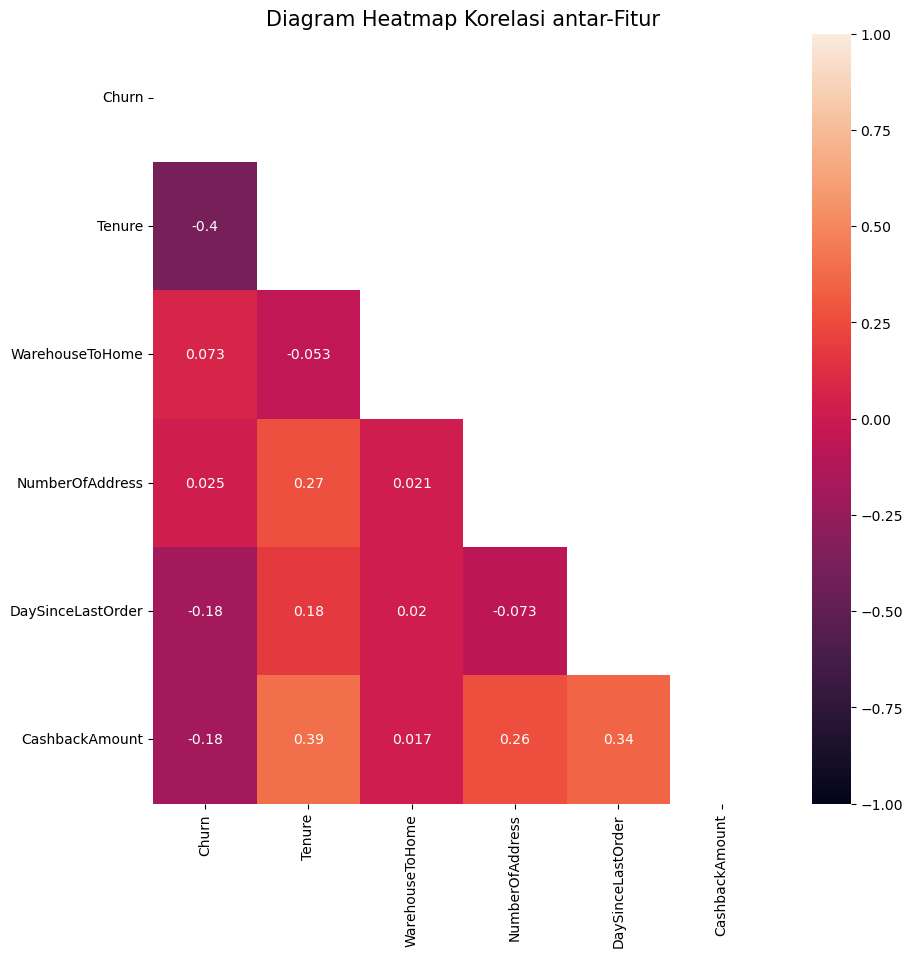

In [251]:
# Correlation Heatmap
corr_mat = df[['Churn','Tenure', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder','CashbackAmount']].corr('spearman')
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)]=True

plt.figure (figsize=(10,10))
plt.title ("Diagram Heatmap Korelasi antar-Fitur", fontsize=15)
sns.heatmap(corr_mat, annot = True, vmax=1, vmin=-1, mask=mask)

plt.show()



Seluruh fitur numerik pada data memiliki korelasi positif di mana terdapat korelasi yang bersignifikasi sedang pada kolom:
* Tenure dan CashbackAmount yang menunjukkan bahwa semakin lama seorang menjadi pelanggan maka semakin banyak jumlah cashback yang diterima (cukup logis)
* Semakin banyak CashbackAmount maka semakin tinggi nilai DaySinceLastOrder (bisa diasumsikan bahwa jumlah promo cashback dulu memang lebih banyak daripada waktu belakangan)
* Semakin baru seseorang menjadi pelanggan, semakin tinggi pelanggan yang churn



## 3. Data Preparation
Data yang digunakan untuk pemodelan adalah data baru yang masih mentah supaya proses data cleaning dapat dilakukan di dalam Pipeline.

### Feature Selection

In [239]:
# Membuat DF yang berisi feature
feature1 = df[['Tenure', 'NumberOfDeviceRegistered',
       'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']]

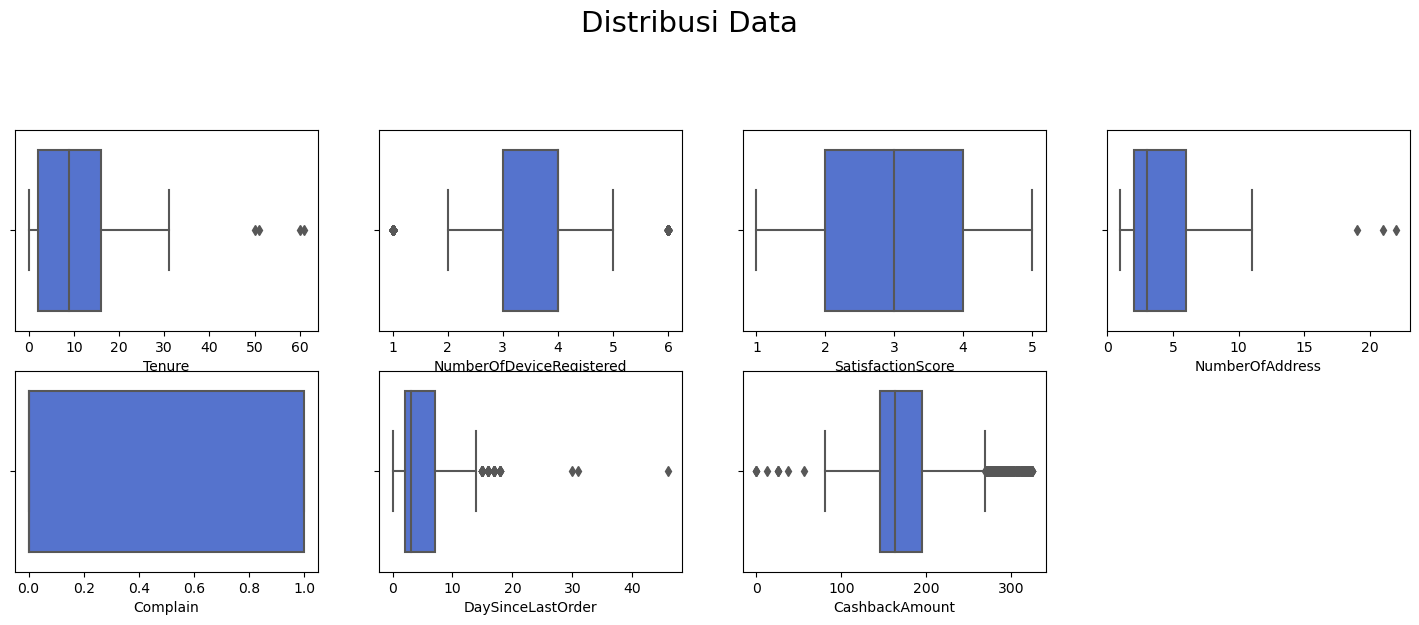

In [240]:
# Boxplot untuk mengecek outlier

plt.figure(figsize=(18,12))

plotnumber=1
for i in feature1:
    plt.subplot(4,4,plotnumber)
    sns.boxplot(data=feature1,x=i, color='royalblue')
    plt.tight_layout

    plotnumber +=1

plt.suptitle('Distribusi Data',size=21)
plt.show()

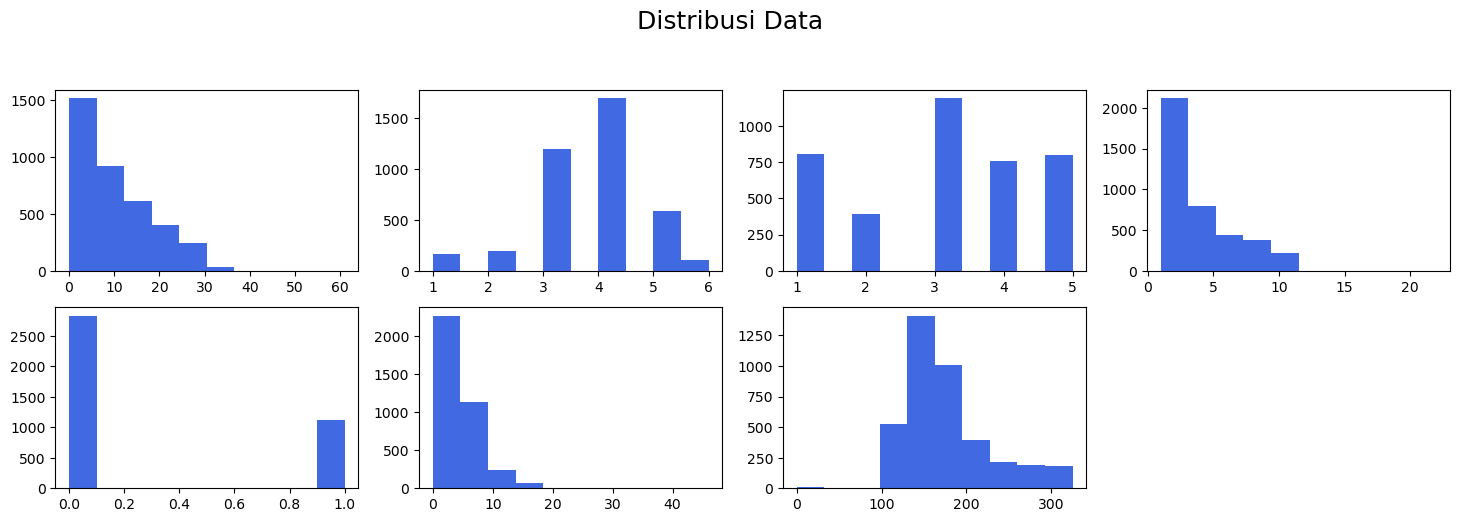

In [241]:
plt.figure(figsize=(18,8))

plotnumber=1
for i in feature1:
    plt.subplot(3,4,plotnumber)
    plt.hist(data=feature1,x=i, color='royalblue')

    plotnumber +=1

plt.suptitle('Distribusi Data',size=18)
plt.show()

In [78]:
# Aggregate Churn Rate by Total Customer
df_churn_percentage = df.groupby('Churn').agg(Population=('Churn','count'))
df_churn_percentage.reset_index(inplace=True)

df_churn_percentage['%Churn'] = round(100*df_churn_percentage['Population']/df_churn_percentage['Population'].sum(),2)

df_churn_percentage

,Churn,Population,%Churn
0,0,3267,82.9
1,1,674,17.1


## 3 Data Preparation
Data yang digunakan untuk pemodelan adalah data baru yang masih mentah supaya proses data cleaning dapat dilakukan di dalam Pipeline.

### 3.1 Split Data

In [124]:
x = b.drop(columns = ['Churn'])
y = b['Churn']

In [125]:
x_train, x_test, y_train, y_test = train_test_split (x, y,stratify=y,test_size = 0.2, random_state= 202)

### 3.2 Data Preprocessing

Data preprocessing yang dilakukan adalah:
1. Handling Missing Value pada kolom Tenure, WarehouseToHome, DaySinceLastOrder dengan mengisi median
2. Menggabungkan data Mobile dan MobilePhone pada PreferedOrderCat menjadi 1 kategori
3. Mengubah PreferedOrderCat, MaritalStatus menggunakan One Hot Encoding, karena fitur tidak memiliki urutan dan memiliki jumlah unique yang sedikit

In [126]:
# fungsi untuk mengubah value pada fitur PreferedOrderCat
def ubahisi (data) :
    data['PreferedOrderCat'] = data['PreferedOrderCat'].replace({'Mobile':'Mobile Phone'})
    return data

In [135]:
pipeline1 = Pipeline ([
    ('name changer', FunctionTransformer(ubahisi)),
    ('one hot encoder', OneHotEncoder(drop='first'))
])

In [136]:
transformer1 = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='median'), ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']),
    ('pipeline', pipeline1, ['PreferedOrderCat']),
    ('onehot2', OneHotEncoder(drop='first'), ['MaritalStatus'])
], remainder = 'passthrough')

## 4. Modeling & Evaluation
Pemilihan basis model yang digunakan adalah: Logistic Regression, K-Nearest Neighbor (KNN), Decision Tree Classifier, Random Forest Classifier, dan XGBoost. Parameter yang digunakan pada basemodel merupakan parameter default. Khusus untuk KNN, value dari data akan di scale terlebih dahulu menggunakan Standard Scaler.

In [137]:
# Define the models that are going to be used
logreg = LogisticRegression(random_state=2020)
knn_scaled = Pipeline ([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
dt = DecisionTreeClassifier(random_state=2020)
rf = RandomForestClassifier(random_state=2020)
xgb = XGBClassifier(random_state=2020)

In [149]:
# Cross Validation
# Define CV method
skfold = StratifiedKFold(n_splits=5)

# Model yang digunakan
models = [logreg, knn_scaled, dt, rf, xgb]
name = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost']

# Scorer yangn digunakan
scorer = {
    'Precision' : 'precision',
    'Recall' : 'recall',
    'F1' : 'f1',
}

### 4.1 Finding Benchmark Model

In [150]:
estimator = Pipeline ([
    ('preprocess', transformer1),
    ('model', logreg)
])
hyperparam_space = {
    'model' : models
}
grid = GridSearchCV (estimator,
                     param_grid = hyperparam_space,    
                     cv = skfold,
                     scoring = scorer,
                     refit = 'Recall', 
                     n_jobs = -1,
                    )

In [151]:
grid.fit (x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Tenure',
                                                                          'WarehouseToHome',
                                                                          'DaySinceLastOrder']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('name '
                                                                                          'changer',
                                   

In [155]:
# Test with data test
estimator = Pipeline ([
    ('preprocess', transformer1),
    ('model', xgb)
])
estimator.fit (x_train, y_train)
y_pred = estimator.predict (x_test)

In [156]:
print ('Precision ', precision_score(y_test, y_pred))
print ('Recall ', recall_score(y_test, y_pred))
print ('F1 score ', f1_score(y_test, y_pred))

# Dari data yang dilihat, tanpa balancing model, model yang terpilih merupakan model XGBoost dengan nilai Recall score 75%

Precision  0.87
Recall  0.75
F1 score  0.8055555555555555


### 4.1.2 Balancing Model
Perlu dilakukan balancing model karena data imbalance sekitar 1:5. Karena data sedikit, jenis resampling yang dipilih tidak menggunakan jenis yang dapat menghapus data, yaitu SMOTE dan RandomOverSampler.

In [301]:
# define oversampler
sm = SMOTE (random_state=2020)
rom = RandomOverSampler(random_state=2020)

In [302]:

# define model
estimator = Pipeline ([
    ('preprocess', transformer1),
    ('balancing', rom),
    ('model', logreg)
])

hyperparam_space = {
    'model' : models,
    'balancing' : [sm, rom]
}

grid = GridSearchCV (estimator,
                     param_grid = hyperparam_space,    
                     cv = skfold,
                     scoring = scorer, 
                     refit = 'Recall',
                     n_jobs = -1,
                    )

In [303]:
# fitting
grid.fit (x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Tenure',
                                                                          'WarehouseToHome',
                                                                          'DaySinceLastOrder']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('name '
                                                                                          'changer',
                                   

In [304]:
hasil_balanced = pd.DataFrame(grid.cv_results_, index=name+name)
hasil_balanced.insert(0, 'Balancing', ['SMOTE']*5+['RandomOverSampler']*5)

In [299]:
hasil_balanced[['param_balancing','mean_test_Recall', 'std_test_Recall']].sort_values('mean_test_Recall', ascending=False)

# Dari hasil evaluasi dibawah ini, KNN dengan balancing RAndomOverSampler akan menjadi model yang paling baik dikarenakan mean test Recallnya pling baik.
# Std Deviasi yang kecil juga menghasilkan model yang baik, hal ini mengindikasikan hasil yang didapat dari model KNN dengan balancing ROS ini cukup konsisten 
# KNN & Logistic menempati posisi 2 model teratas berdasarkan tabel hasilnya. Sehingga kita akan melakukan prediksi pada data testing untuk KNN & Logistic Regression dengan balancing RandomOverSampler

,param_balancing,mean_test_Recall,std_test_Recall
KNN,RandomOverSampler(random_state=2020),0.836255,0.036684
Logistic Regression,RandomOverSampler(random_state=2020),0.797382,0.021158
Logistic Regression,SMOTE(random_state=2020),0.795278,0.013291
KNN,SMOTE(random_state=2020),0.784455,0.027413
XGBoost,RandomOverSampler(random_state=2020),0.762856,0.050820
Random Forest,RandomOverSampler(random_state=2020),0.734829,0.079212
XGBoost,SMOTE(random_state=2020),0.724194,0.031879
Decision Tree,RandomOverSampler(random_state=2020),0.674638,0.054190
Decision Tree,SMOTE(random_state=2020),0.670266,0.010638
Random Forest,SMOTE(random_state=2020),0.668139,0.084905


In [258]:
# Data Test dicoba di logreg, knn
test_result = []
for i in [knn_scaled, logreg] :
    estimator = Pipeline ([
        ('preprocess', transformer1),
        ('balancing', rom),
        ('model', i)
    ])
    estimator.fit (x_train, y_train)
    y_pred = estimator.predict (x_test)
    
    test_result.append (
        [precision_score(y_test, y_pred),
         recall_score(y_test, y_pred),
         f1_score(y_test, y_pred)]
    )

In [259]:
pd.DataFrame (data=test_result, index = ['KNN','Logistic Regression'], columns = scorer.keys())

,Precision,Recall,F1
KNN,0.510753,0.818966,0.629139
Logistic Regression,0.409483,0.818966,0.545977


In [288]:
param_grid = {'model__n_neighbors': [1,3,5,9],
              'model__weights':['uniform','distance']}

In [289]:
estimator = Pipeline ([
    ('preprocess', transformer1),
    ('balancing', rom),
    ('model', KNeighborsClassifier())
])

kfold=KFold(n_splits=5)

randomsearch_tree = RandomizedSearchCV (estimator=estimator,
                     param_distributions=param_grid ,    
                     cv = kfold,
                     scoring = scorer, 
                     refit = 'Recall',
                     n_jobs = -1,
                    )

In [290]:
randomsearch_tree.fit(x_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imputer',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'DaySinceLastOrder']),
                                                                              ('pipeline',
                                                                               Pipeline(steps=[('name '
                                                                                      

In [291]:
y_pred = randomsearch_tree.predict(x_test)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [293]:
randomsearch_tree.best_params_

{'model__weights': 'distance', 'model__n_neighbors': 9}

In [292]:
# Evaluation Matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       566
           1       0.50      0.83      0.62       116

    accuracy                           0.83       682
   macro avg       0.73      0.83      0.76       682
weighted avg       0.88      0.83      0.84       682



In [295]:
# Final Model

model_govan = randomsearch_tree.best_estimator_

## PICKLE

In [296]:
import pickle as pickle

### Save Machine Learning

In [ ]:
pipe_model=Pipeline([('preprocessing',transformer1),('model',XGBRegressor())])
pipe_model.fit(x_train, y_train)

pickle.dump(pipe_model, open('ecommerce_customer_churn.sav', 'wb'))